<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [1]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [2]:
import os

if not (
  os.path.exists("blur") and
  os.path.exists("contrast") and
  os.path.exists("jpeg") and
  os.path.exists("jpeg2000") and
  os.path.exists("fnoise")
):
  !wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
  !wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip

  !unzip -n src_imgs.zip
  !unzip -n dst_imgs.zip
else:
  print("images found, skipping.")

--2021-01-15 14:15:12--  http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14455692 (14M) [application/zip]
Saving to: ‘src_imgs.zip’

src_imgs.zip        100%[===================>]  13.79M  6.25MB/s    in 2.2s    

2021-01-15 14:15:14 (6.25 MB/s) - ‘src_imgs.zip’ saved [14455692/14455692]

--2021-01-15 14:15:15--  http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip
Resolving vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)... 133.70.150.170
Connecting to vision.eng.shizuoka.ac.jp (vision.eng.shizuoka.ac.jp)|133.70.150.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374383009 (357M) [application/zip]
Saving to: ‘dst_imgs.zip’

dst_imgs.zip        100%[===================>] 357.04M  11.1MB/s    in 34s     

2021-01-15 1

# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [3]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['boston', 'log_seaside', 'foxy', 'shroom', 'sunset_sparrow', 'geckos', 'turtle', 'veggies', 'rushmore', 'roping', 'lady_liberty', 'snow_leaves', 'cactus', 'sunsetcolor', 'couple', 'child_swimming', '1600', 'trolley', 'woman', 'elk', 'native_american', 'family', 'butter_flower', 'lake', 'fisher', 'bridge', 'swarm', 'aerial_city', 'monument', 'redwood']


In [4]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']
NR_IMG = 10 # 'ALL' 10, 20 ...

if NR_IMG == 'ALL':
  NR_IMG = len(img_list)

print(NR_IMG)

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems):
  
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, NR_IMG)

print("Nr of img:",len(images['orig']))


10
Nr of img: 10


In [5]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False, columns = 5):
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


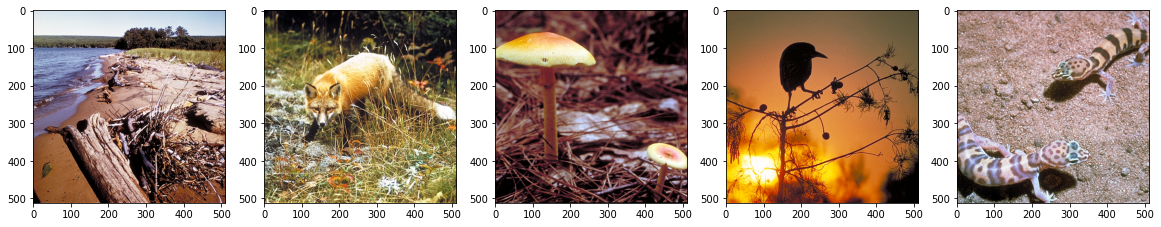

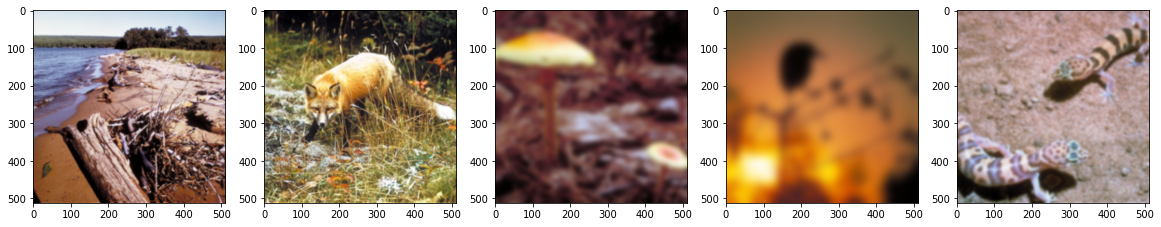

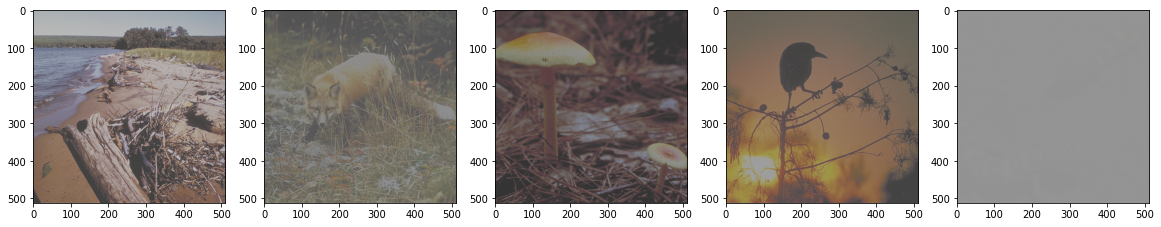

In [6]:
#Print some stats
max_to_show = min(NR_IMG,5)
rand_idx = randint(0, len(images['orig'])-max_to_show)
plot_all(images['orig'][rand_idx:rand_idx+max_to_show])
plot_all(images['blur']['5'][rand_idx:rand_idx+max_to_show])
plot_all(images['contrast']['5'][rand_idx:rand_idx+max_to_show])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [7]:
!pip install tqdm

In [8]:
#Calculate the number of patches


OWH = 512 # 512 x 512
WH = 32 #
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = int(int(OWH / WH) * int(OWH / WH))

print(PATCH_COUNT)

256


In [9]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,WH,WH,3))
  patches = np.sum(patches/3, axis=3, keepdims=True)
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = (score + 1) / 2
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


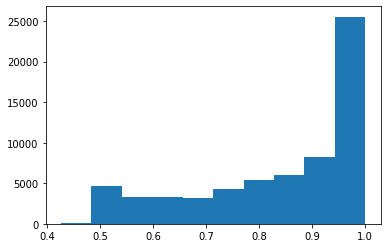

0.4258233212924365

In [10]:
plt.hist(np.array(scores).flatten())
plt.show()

min(np.array(scores).flatten())

## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [11]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile = 30
  batch_percentile = np.percentile(batch,percentile)
  omega_p_sum = sum([i for i in batch if i <= batch_percentile])
  c = all_sum / (percentile * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(10, 5, 5, 256)
0.12336083294154715
comparing for 6
(img-6 dist-2 qual-1)


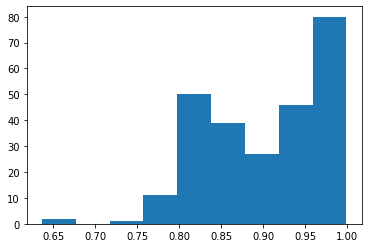

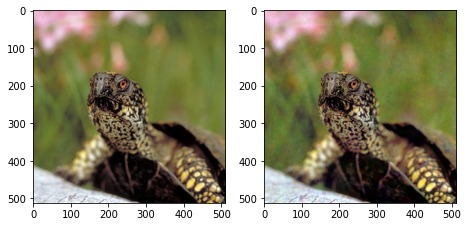

In [12]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [13]:
norm_scores = np.copy(scores)
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
norm_scores = np.interp(norm_scores, (norm_scores.min(), norm_scores.max()), (0, +1))


(img-6 dist-fnoise qual-2)


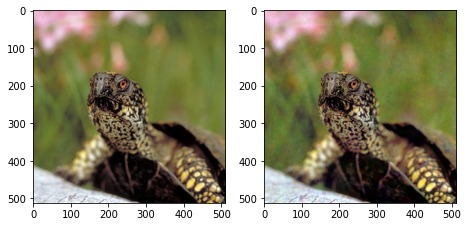

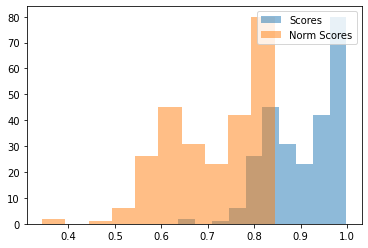

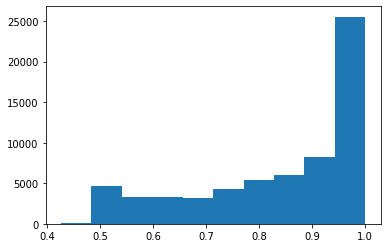

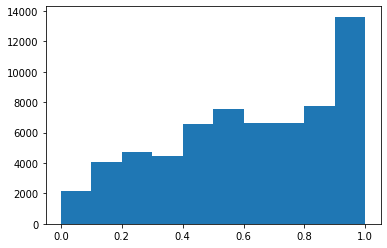

min scores 0.4258233212924365, min norm_scores 0.0, max scores 1.0, max norm_scores 1.0


In [14]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))


plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plt.hist(np.array(scores).flatten())
plt.show()
plt.hist(np.array(norm_scores).flatten())
plt.show()

print("min scores {}, min norm_scores {}, max scores {}, max norm_scores {}".format(min(np.array(scores).flatten()), min(np.array(norm_scores).flatten()), max(np.array(scores).flatten()), max(np.array(norm_scores).flatten())))

## Score QAC - Quality Aware Clusters

[3, 4, 5, 6, 7, 8, 9, 10]
[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(10, 5, 5, 256)
(5, 5, 256)
(10, 5, 5, 256)
{0.9, 1.0, 0.6, 0.8, 0.5, 0.7, 0.4, 0.3}


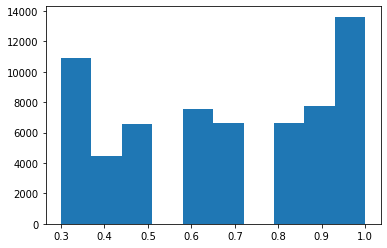

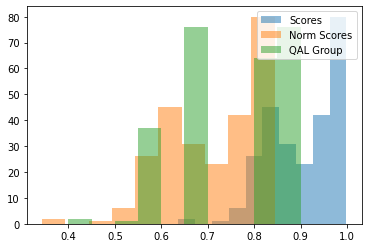

In [15]:
# Define The Score Levels used in QAC

L = 10 # The Score Levels used in QAC
SA = 3 # start class
Gl = list(range(SA,L+1))
print(Gl)
Gl[:] = [x / 10 for x in Gl]

one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

classes = set([]) 

print(Gl)
print(np.array(G).shape)
print(np.array(one_group).shape)
print(np.array(norm_scores).shape)

for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
# for i in range(ri,i+1):
#   for d in range(rd,rd+1):
#     for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        G[i][d][q][p] = Gl[L-SA]
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            classes.add(score_l)
            break

print(classes)
            
plt.hist(np.array(G).flatten())
plt.show()

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

# Model Training (Keras)

## Extract Features (?)

## High pass filter - Difference of Gaussian (DoG) ( ![alt text]( https://latex.codecogs.com/gif.latex?h_%7B%5Csigma%20%7D%28r%29%3D1_%7Br%3D0%20%7D-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%5Cpi%20%5Csigma%20%7D%7Dexp%28-%5Cfrac%7Br%5E%7B2%7D%7D%7B2%5Csigma%20%5E%7B2%7D%7D%29) )

In [16]:
from skimage import filters, color

def dog(patch, sigma):
  k = 1.6
  s1 = filters.gaussian(patch,k*sigma)
  s2 = filters.gaussian(patch,sigma)
  # multiply by sigma to get scale invariance
  dog = s1 - s2
  return dog

#Sigmas: [0.2, 2.0, 4.0]

def all_filtered_patches(all_patches, sigma):
  all_filtered = []
  for i in tqdm(range(len(all_patches))):
    patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
    gray_patch = patch
    filtered = dog(gray_patch, sigma)
    all_filtered.append(filtered)
  return all_filtered

fa = all_filtered_patches(all_patches, 0.5)
fb = all_filtered_patches(all_patches, 2.0)
fc = all_filtered_patches(all_patches, 4.0)

100%|██████████| 64000/64000 [00:28<00:00, 2263.62it/s]


In [17]:

# all_filtered = all_patches
all_filtered = np.concatenate((fa, fb, fc),axis=2)
print (np.array(all_filtered).shape)

(64000, 32, 96, 1)


## Split training / validation


train:
(54400, 32, 96, 1)
(54400,)

 y categorical:
(54400, 8)
(9600, 8)

validation:
(9600, 32, 96, 1)
(9600,)

Total:
(64000, 32, 32, 1)
(64000,)
Counter({1.0: 11569, 0.3: 9308, 0.9: 6622, 0.6: 6407, 0.7: 5638, 0.8: 5581, 0.5: 5512, 0.4: 3763})
Counter({1.0: 2043, 0.3: 1614, 0.6: 1131, 0.9: 1117, 0.8: 1027, 0.5: 1023, 0.7: 957, 0.4: 688})


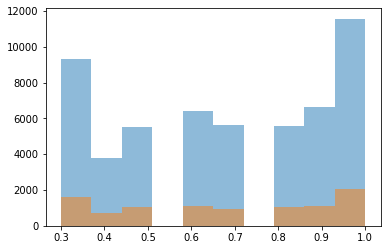

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow import keras 

import collections

all_scores = np.array(G).flatten()

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_filtered), np.array(all_scores), test_size=0.15, shuffle= True)


num_classes = len(classes)

y_train_c = keras.utils.to_categorical(np.digitize(y_train, Gl)-1, num_classes)
y_valid_c = keras.utils.to_categorical(np.digitize(y_valid, Gl)-1, num_classes)

print("\ntrain:")
print(np.array(x_train).shape)
print(np.array(y_train).shape)

print("\n y categorical:")
print(np.array(y_train_c).shape)
print(np.array(y_valid_c).shape)

print("\nvalidation:")
print(np.array(x_valid).shape)
print(np.array(y_valid).shape)

print("\nTotal:")
print(np.array(all_patches).shape)
print(np.array(all_scores).shape)

counter=collections.Counter(y_train)
print(counter)

counter=collections.Counter(y_valid)
print(counter)

plt.hist(y_train, alpha=0.5)
plt.hist(y_valid, alpha=0.5)
plt.show()

Counter({(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 11569, (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 9308, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 6622, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 6407, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 5638, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 5581, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 5512, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 3763})


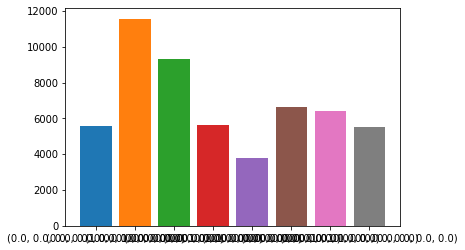

In [19]:
counter=collections.Counter([tuple(i) for i in y_train_c])
print(counter)

dic = dict(counter)
for key in dic.keys():
  plt.bar(str(key), dic[key])
plt.show()

## Declare the model

In [20]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf
import keras
from keras import layers
from keras import optimizers

model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax')) 

# Train model
# sgd = SGD(lr=0.005)
opt = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 96, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 24, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 24, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 12, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

## Train

In [21]:
#Early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=7, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

#fit the model
fit_his = model.fit(x = x_train, y = y_train_c, validation_split=0.2, batch_size = 140, verbose=2, epochs=50, callbacks=[es])


Epoch 1/50
311/311 - 9s - loss: 1.7636 - accuracy: 0.3459 - val_loss: 1.6311 - val_accuracy: 0.3767
Epoch 2/50
311/311 - 2s - loss: 1.5780 - accuracy: 0.3998 - val_loss: 1.5551 - val_accuracy: 0.4042
Epoch 3/50
311/311 - 2s - loss: 1.4998 - accuracy: 0.4257 - val_loss: 1.5089 - val_accuracy: 0.4283
Epoch 4/50
311/311 - 2s - loss: 1.4381 - accuracy: 0.4515 - val_loss: 1.4830 - val_accuracy: 0.4372
Epoch 5/50
311/311 - 2s - loss: 1.3782 - accuracy: 0.4708 - val_loss: 1.4530 - val_accuracy: 0.4395
Epoch 6/50
311/311 - 2s - loss: 1.3253 - accuracy: 0.4880 - val_loss: 1.4245 - val_accuracy: 0.4390
Epoch 7/50
311/311 - 2s - loss: 1.2655 - accuracy: 0.5092 - val_loss: 1.3920 - val_accuracy: 0.4540
Epoch 8/50
311/311 - 2s - loss: 1.2211 - accuracy: 0.5275 - val_loss: 1.3802 - val_accuracy: 0.4669
Epoch 9/50
311/311 - 2s - loss: 1.1799 - accuracy: 0.5439 - val_loss: 1.3641 - val_accuracy: 0.4663
Epoch 10/50
311/311 - 2s - loss: 1.1376 - accuracy: 0.5605 - val_loss: 1.3549 - val_accuracy: 0.4760

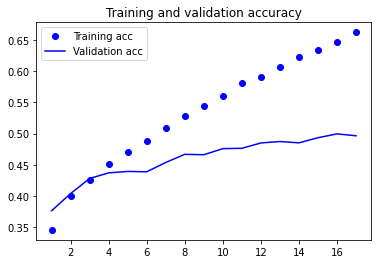

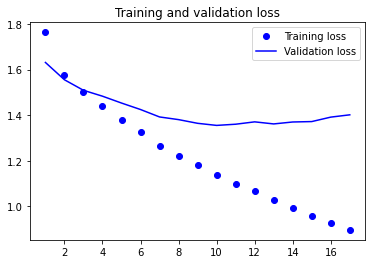

In [22]:
acc = fit_his.history['accuracy']
val_acc = fit_his.history['val_accuracy']
loss = fit_his.history['loss']
val_loss = fit_his.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Validate

In [23]:
#evaluate on unseen data
score = model.evaluate(x_valid, y_valid_c, verbose=1)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

300/300 [==============================] - 1s 2ms/step - loss: 1.3480 - accuracy: 0.4850
Test accuarcy: 48.50%


predicting for 4510 to 4542


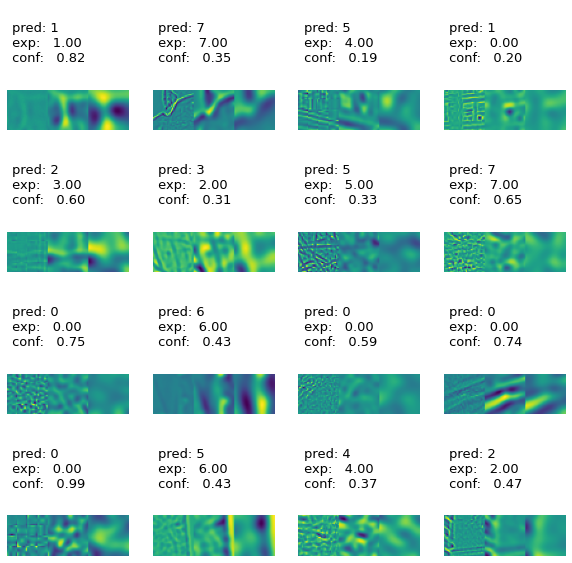

In [24]:
from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, y):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    yaxes = i // 4
    xaxes = i % 4
    axes[xaxes, yaxes].axis('off')

    pred = np.argmax(predictions[i])
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[xaxes, yaxes].imshow(images[i])
    axes[xaxes, yaxes].text(0.5, 0.5, "\n pred: {0}\n exp: {1:6.2f}\n conf: {2:6.2f} \n\n".format(pred, np.argmax(y[i]), confidence) , fontsize=13)

  pyplot.gcf().set_size_inches(10, 10)

nr_ex = 32
start_from = randint(0, x_valid.shape[0]-nr_ex)
# start_from = 0
print("predicting for {} to {}".format(start_from, start_from+nr_ex))

# pred_y = model.predict(x_valid[start_from:start_from+nr_ex])

# max_pred = [np.argmax(y) for y in pred_y]
# print(max_pred)
# print(y_valid_oh[start_from:start_from+nr_ex])

plot_predictions(np.squeeze(x_valid[start_from:start_from+16]), model.predict(x_train[start_from:start_from+16]), y_train_c[start_from:start_from+16])

In [52]:
# Code to save the model into your google drive

# !pip install PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# model_name = 'biqa_model_{}.h5'.format(str(uuid.uuid4()))

# model.save(model_name)

# # get the folder id where you want to save your file
# file = drive.CreateFile({'parents':[{u'id': "1Iu9bS-fovG20py9_9A2-M7BJ56HG-sNB"}]})
# file.SetContentFile(model_name)
# file.Upload()
# print(file['id'])

# Predict on images

In [44]:

def test_pred(to_predict):
  predictions = []
  for pred_img in to_predict:
    ex_patches = extract_patches(pred_img)
    fa = all_filtered_patches(ex_patches, 0.5)
    fb = all_filtered_patches(ex_patches, 2.0)
    fc = all_filtered_patches(ex_patches, 4.0)
    pred_patches = np.concatenate((fa, fb, fc),axis=2)
    pred_scores = model.predict(pred_patches)

    #Build the image based on scores
    pred_args = []
    for p in pred_scores:
      pred_args.append(np.argmax(p))
    avg = np.mean(pred_args)
    predictions.append(avg)
  return predictions
#   plt.hist(pred_args)

  0%|          | 0/256 [00:00<?, ?it/s]

Distortions: contrast


100%|██████████| 256/256 [00:00<00:00, 2374.12it/s]


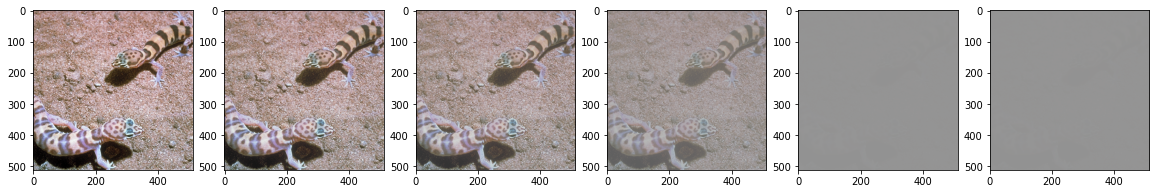

[6.9921875, 6.96875, 6.9296875, 5.25, 0.0, 0.0]


In [65]:
# Set 1

i = randint(0,NR_IMG-1)
d = randint(0, len(DISTORT)-1)
dist = DISTORT[d]
to_predict = [images['orig'][i], images[dist]['1'][i], images[dist]['2'][i], images[dist]['3'][i], images[dist]['4'][i], images[dist]['5'][i]]
print("Distortions: {}".format(dist))
p = test_pred(to_predict)
plot_all(to_predict, columns=6)
print(p)

  0%|          | 0/256 [00:00<?, ?it/s]

Distortions: jpeg


100%|██████████| 256/256 [00:00<00:00, 2313.44it/s]


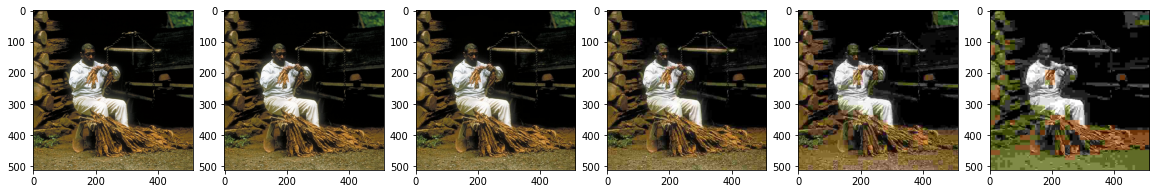

In [66]:
# Set 2

i = randint(0,NR_IMG-1)
d = randint(0, len(DISTORT)-1)
dist = DISTORT[d]
to_predict = [images['orig'][i], images[dist]['1'][i], images[dist]['2'][i], images[dist]['3'][i], images[dist]['4'][i], images[dist]['5'][i]]

print("Distortions: {}".format(dist))
test_pred(to_predict)
plot_all(to_predict, columns=6)

In [55]:
!wget -nc https://www.invite-hotels.de/images/pictures/w7e1a130f291a00323bbb294ee1c23b0/w7e1b140b2b37001fbc1c9ab2e6af7cf/metropol_0516_07.jpg?w=512&h=512&r=3
!wget -nc https://content3.jdmagicbox.com/comp/anantnag/w9/9999p1932.1932.130810120812.t2w9/catalogue/hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg
!wget -nc https://cdn.arstechnica.net/wp-content/uploads/2020/02/foss-mascots.png

File ‘metropol_0516_07.jpg?w=512’ already there; not retrieving.

File ‘hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg’ already there; not retrieving.

--2021-01-15 14:35:10--  https://cdn.arstechnica.net/wp-content/uploads/2020/02/foss-mascots.png
Resolving cdn.arstechnica.net (cdn.arstechnica.net)... 205.234.175.175
Connecting to cdn.arstechnica.net (cdn.arstechnica.net)|205.234.175.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2272058 (2.2M) [image/png]
Saving to: ‘foss-mascots.png’

foss-mascots.png    100%[===================>]   2.17M  --.-KB/s    in 0.08s   

2021-01-15 14:35:11 (27.7 MB/s) - ‘foss-mascots.png’ saved [2272058/2272058]



100%|██████████| 2728/2728 [00:01<00:00, 2230.76it/s]


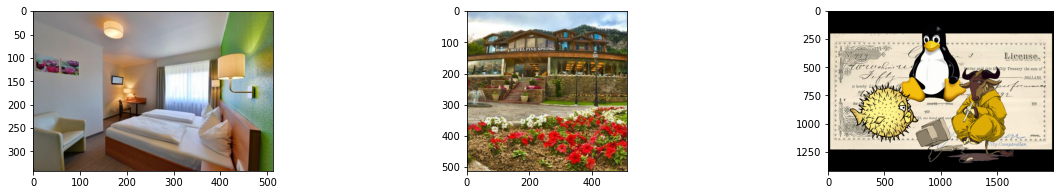

[1.9375, 2.73828125, 1.6282991202346042]


In [56]:
from_web = ['metropol_0516_07.jpg?w=512', 'hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg', 'foss-mascots.png']
images_from_web = []

for img_from_web in from_web:
  img_data = cv2.imread(img_from_web)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
  images_from_web.append(img_data)

p = test_pred(images_from_web)
plot_all(images_from_web, columns=3)
print(p)